In [ ]:
!pip install lightkurve

In [165]:
import lightkurve as lk

In [193]:
target = input("Enter a target (Example: Kepler-17):")

Enter a target (Example: Kepler-17):Kepler-4


In [194]:
pixelfile = lk.search_targetpixelfile(target)[1].download()

In [195]:
pixelfile

KeplerTargetPixelFile Object (ID: 11853905)

In [196]:
lc = pixelfile.to_lightcurve(method="pld").remove_outliers().flatten()

In [197]:
period1 = lc.to_periodogram("bls").period_at_max_power
#lc.fold(period1).scatter()
times2 = lc.fold(period1).time.value

In [198]:
planet_t0 = lc.to_periodogram("bls").transit_time_at_max_power
planet_dur = lc.to_periodogram("bls").duration_at_max_power

In [199]:
planet_model = lc.to_periodogram("bls").get_transit_model(period=period1,
                                       transit_time=planet_t0,
                                       duration=planet_dur)

In [200]:
period1.value

3.215325663062248

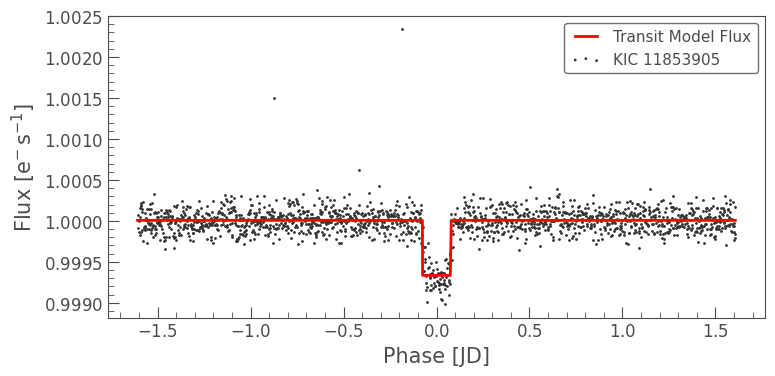

In [201]:
ax = lc.fold(period1, planet_t0).scatter()
planet_model1 = planet_model.fold(period1, planet_t0).plot(ax=ax, c='r', lw=2)
#ax.set_xlim(-5, 5);

In [202]:
times1 = planet_model.time.value

In [203]:
import numpy as np
ax1 = lc.fold(period1, planet_t0)
np.std(ax1.flux)

<Quantity 0.00020301 electron / s>

In [204]:
ax1.flux

<Quantity [1.00001083, 1.00007422, 0.99991062, ..., 1.00017079, 0.99979303,
           0.99983981] electron / s>

In [205]:
summation = 0
for i in range(0,len(ax1.flux)):
    summation += ((ax1[i][1]-planet_model[i][1])**2)/(np.std(ax1.flux)**2)
    
print(summation/4000)

0.5863036012545474


In [206]:
!pip install pytransit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install corner

In [ ]:
!pip install celerite

In [ ]:
!pip install emcee

In [97]:
from numpy import percentile
from matplotlib import rc
from matplotlib.pyplot import subplots, setp
from corner import corner
from pytransit import TransitAnalysis

In [207]:
times1

array([131.51232472, 131.53275902, 131.55319322, ..., 164.94253423,
       164.96296814, 164.98340215])

In [208]:
ta = TransitAnalysis(name='model_1', passbands='Kepler', times=times2, fluxes=ax1.flux.value)

In [209]:
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_Kepler      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_Kepler      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


In [210]:
period1.value

3.215325663062248

In [211]:
ta.set_prior('p_1', 'NP', period1.value, 0.001)

In [212]:
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 3.215325663062248, σ = 0.001)      [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_Kepler      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_Kepler      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

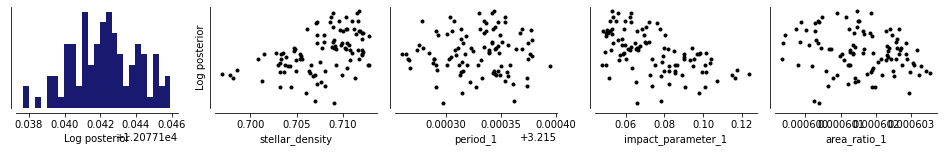

In [213]:
ta.optimize_global(niter=500, npop=100)

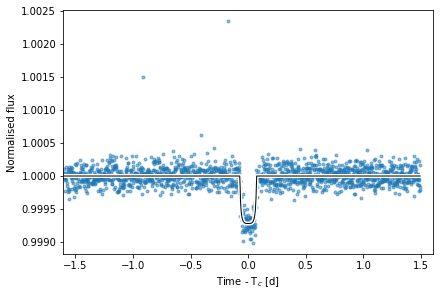

In [214]:
ta.plot_light_curves(method="fit");

In [215]:
ta.sample_mcmc(niter=2000, thin=20, repeats=3, save=False)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/2000 [00:00<?, ?it/s]

In [216]:
ta.save()

/usr/local/lib/python3.7/dist-packages/arviz/data/inference_data.py:1363: UserWarning: The group derived_parameters is not defined in the InferenceData scheme
  UserWarning,


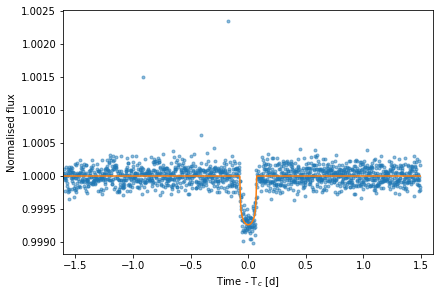

In [217]:
ta.plot_light_curves(method='posterior');

In [218]:
df = ta.posterior_samples()

/usr/local/lib/python3.7/dist-packages/arviz/data/inference_data.py:1363: UserWarning: The group derived_parameters is not defined in the InferenceData scheme
  UserWarning,


In [219]:
df

Inference data with groups:
	> posterior
	> sample_stats
	> derived_parameters